In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
#import scipy.stats as stats
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [2]:
style.use('seaborn-ticks')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# Model dynamics

In [44]:
NRUNS = 5
burn_in_period = 0

In [45]:
#scenarios = [None, 'BLR', 'BUSTQE', 'BUSTQT', 'BOOMQE', 'BOOMQT']
scenarios = [None, 'BLR', 'BUSTQE', 'BOOMQT']

In [46]:
params_nb = {"fundamental_value": 105,
              "trader_sample_size": 15, "n_traders": 500,
              "ticks": 500, "std_fundamental": 0.01,
              "std_noise": 0.159, "w_random": 0.25,
              "strat_share_chartists": 0.20,
              "init_assets": 740, "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.02, 'money_multiplier': 2.6,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
              "qe_perc_size": 0.16, "cb_size": 0.02, "qe_asset_index": 0}

In [47]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []
cb_asset_values = []
cb_currencies = []

for scenario in scenarios:
    trdrs = []
    orbs = []
    central_banks = []

    for seed_nb in range(NRUNS): 
        traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
        traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
        central_banks.append(central_bank_nb)
        trdrs.append(traders_nb)
        orbs.append(orderbook_nb)
    
    prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
    fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
    volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
    qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
    qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())
    
    cb_asset_values.append(pd.DataFrame([np.array(orbs[run].tick_close_price[2:]) * np.array(central_banks[run].var.assets) for run in range(NRUNS)]).transpose())
    cb_currencies.append(pd.DataFrame([central_banks[run].var.currency for run in range(NRUNS)]).transpose())
    

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443

216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
46

605
cb QE
cb QE
cb QE
606
cb QE
cb QE
cb QE
607
cb QE
cb QE
cb QE
608
cb QE
cb QE
cb QE
609
cb QE
cb QE
610
cb QT
cb QT
cb QT
611
cb QT
cb QT
cb QT
612
cb QT
cb QT
cb QT
613
cb QT
cb QT
cb QT
614
cb QT
cb QT
cb QT
615
cb QT
cb QT
cb QT
616
cb QT
617
618
619
cb QE
cb QE
620
621
cb QE
cb QE
622
cb QE
cb QE
623
cb QE
624
625
626
627
628
cb QE
cb QE
cb QE
629
cb QE
cb QE
630
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
639
cb QE
cb QE
640
cb QE
cb QT
641
cb QT
cb QT
cb QT
642
cb QT
cb QT
cb QT
643
cb QT
cb QT
644
cb QT
cb QT
645
cb QT
cb QT
cb QT
646
cb QT
647
cb QT
cb QT
648
cb QT
cb QT
cb QT
649
cb QT
cb QT
cb QT
650
cb QT
cb QT
cb QT
651
cb QT
cb QT
cb QT
652
cb QT
cb QT
cb QT
653
654
655
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb

cb QT
631
cb QT
cb QT
cb QT
632
cb QT
cb QT
cb QT
633
cb QT
cb QT
cb QT
634
cb QT
cb QT
cb QT
635
636
637
cb QE
cb QE
cb QE
638
cb QE
639
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
642
643
644
645
cb QT
cb QT
cb QT
646
647
648
649
650
651
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
659
cb QT
cb QT
660
cb QT
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
667
668
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
675
676
677
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
683
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QT
689
cb QT
cb QT
cb QT
690
cb QT
cb QT
cb QT
691
cb QT
cb QT
cb QT
692
cb QT
cb QT
cb QT
693
694
cb QE
cb QE


209
cb QT
cb QT
cb QT
210
cb QT
cb QT
cb QT
211
cb QT
cb QT
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
216
cb QT
cb QT
217
cb QT
cb QT
cb QT
218
cb QT
cb QT
cb QT
219
cb QT
cb QT
cb QT
220
cb QT
cb QT
cb QT
221
cb QT
cb QT
cb QT
222
cb QT
cb QT
cb QT
223
cb QT
cb QT
cb QT
224
cb QT
cb QT
cb QT
225
cb QT
cb QT
cb QT
226
cb QT
cb QT
cb QT
227
cb QT
cb QT
cb QT
228
cb QT
229
230
231
232
cb QT
233
cb QT
cb QT
234
cb QT
cb QT
235
cb QT
cb QT
cb QT
236
cb QT
cb QT
cb QT
237
cb QT
cb QT
cb QT
238
239
240
241
242
cb QE
cb QE
243
cb QE
cb QE
cb QE
244
cb QE
cb QE
cb QE
245
cb QE
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
cb QE
cb QE
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
254
255
256
cb QT
cb QT
cb QT
257
cb QT
cb QT
cb QT
258
cb QT
cb QT
cb QT
259
cb QT
260
261
262
263
264
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE


233
cb QT
cb QT
cb QT
234
cb QT
cb QT
cb QT
235
cb QT
cb QT
cb QT
236
cb QT
cb QT
cb QT
237
cb QT
238
239
cb QE
cb QE
240
cb QE
cb QE
cb QE
241
cb QE
cb QE
cb QE
242
cb QE
cb QE
243
244
245
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
cb QE
cb QE
cb QE
252
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
262
cb QE
263
cb QE
cb QE
cb QE
264
265
cb QE
266
cb QE
cb QE
cb QE
267
268
269
270
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
284
285
286
287
288
289
cb QT
cb QT
cb QT
290
cb QT
cb QT
cb QT
291
cb QT
cb QT
cb QT
292
cb QT
cb QT
cb QT
293
cb QT
cb QT
294
cb

476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
2

372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
cb QE
494
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
cb QE
cb QE
497
cb QE
cb QE
cb QE
498
cb QE
cb QE
cb QE
499
cb QE
cb QE
cb QE
500
cb QE
cb QE
cb QE
501
cb QE
cb QE
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
57

274
cb QT
cb QT
cb QT
275
cb QT
cb QT
cb QT
276
277
278
279
280
cb QT
281
cb QT
cb QT
cb QT
282
cb QT
cb QT
cb QT
283
cb QT
cb QT
cb QT
284
cb QT
cb QT
cb QT
285
cb QT
cb QT
cb QT
286
287
cb QT
cb QT
cb QT
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
cb QT
cb QT
303
cb QT
cb QT
cb QT
304
cb QT
cb QT
cb QT
305
cb QT
cb QT
cb QT
306
cb QT
cb QT
cb QT
307
cb QT
cb QT
308
cb QT
cb QT
cb QT
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
cb QT
381
cb QT
cb QT
cb QT
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
45

543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


## For BustQE, BoomQT & BLR show:

Prices compared to no-QE + cb balance sheet. 

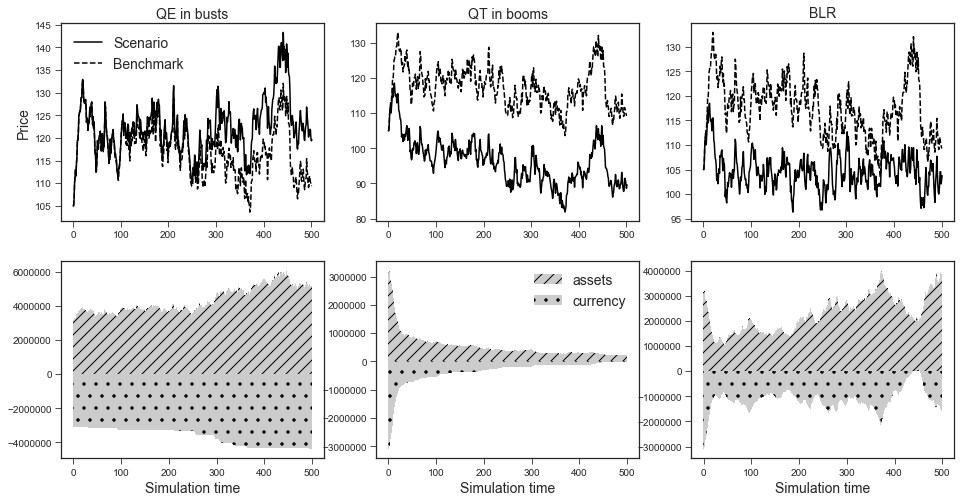

In [73]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,8))

# price bustQE
s_idx = 2
ax1.set_title('QE in busts', fontsize='14')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), 'k-', label='Scenario')
ax1.plot(prices[0].index, prices[0].mean(axis=1), 'k--', label='Benchmark')
ax1.set_ylabel('Price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

# price boomQT
s_idx = 3
ax2.set_title('QT in booms', fontsize='14')
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), 'k-', label=scenarios[s_idx])
ax2.plot(prices[0].index, prices[0].mean(axis=1), 'k--', label='Benchmark')
#ax2.set_ylabel('Price')

# price BLR
s_idx = 1
ax3.set_title('BLR', fontsize='14')
ax3.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), 'k-', label=scenarios[s_idx])
ax3.plot(prices[0].index, prices[0].mean(axis=1), 'k--', label='Benchmark')
#ax3.set_ylabel('Price')

# Central bank balance sheets
ax4.bar(cb_asset_values[2].index, cb_asset_values[2].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax4.bar(cb_currencies[2].index, cb_currencies[2].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')

# Central bank balance sheets
ax5.bar(cb_asset_values[3].index, cb_asset_values[3].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax5.bar(cb_currencies[3].index, cb_currencies[3].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')
ax5.legend(loc='best', fontsize='14')

# Central bank balance sheets
ax6.bar(cb_asset_values[1].index, cb_asset_values[1].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax6.bar(cb_currencies[1].index, cb_currencies[1].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')

for ax in (ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')

fig.savefig('qe_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# BLR

Text(0, 0.5, 'Volume')

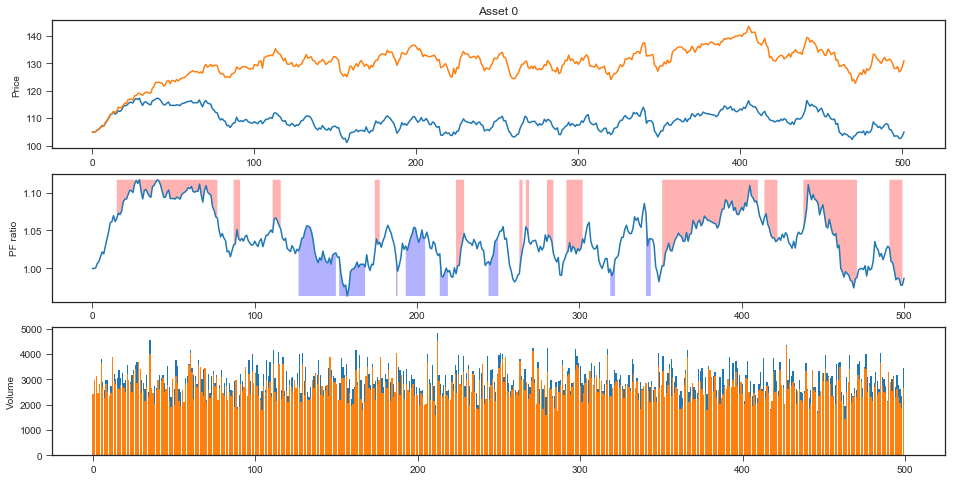

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 1

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Bust QE

Text(0, 0.5, 'Volume')

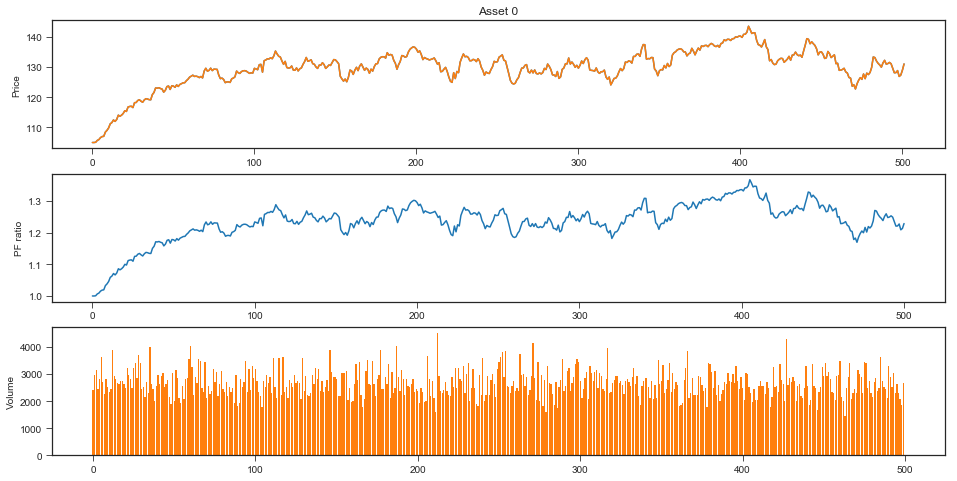

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 2

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Bust QT

Text(0, 0.5, 'Volume')

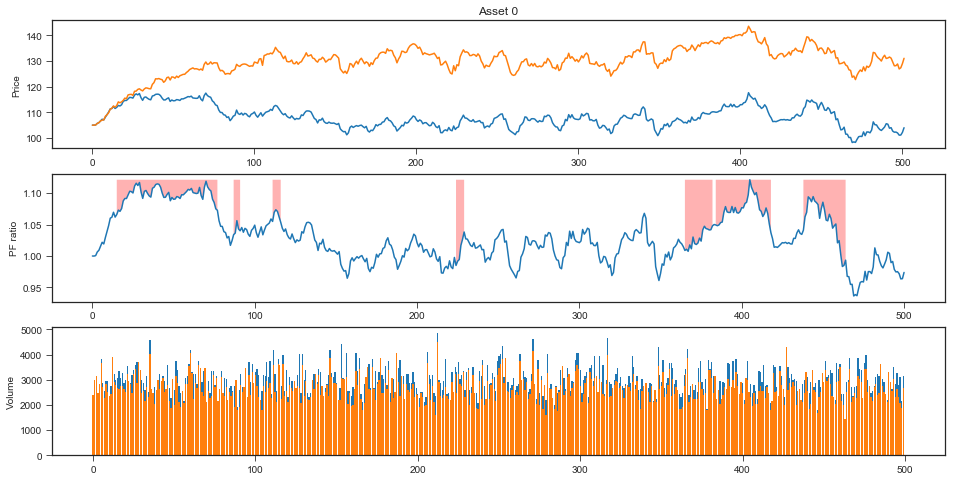

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 3

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Boom QE

IndexError: list index out of range

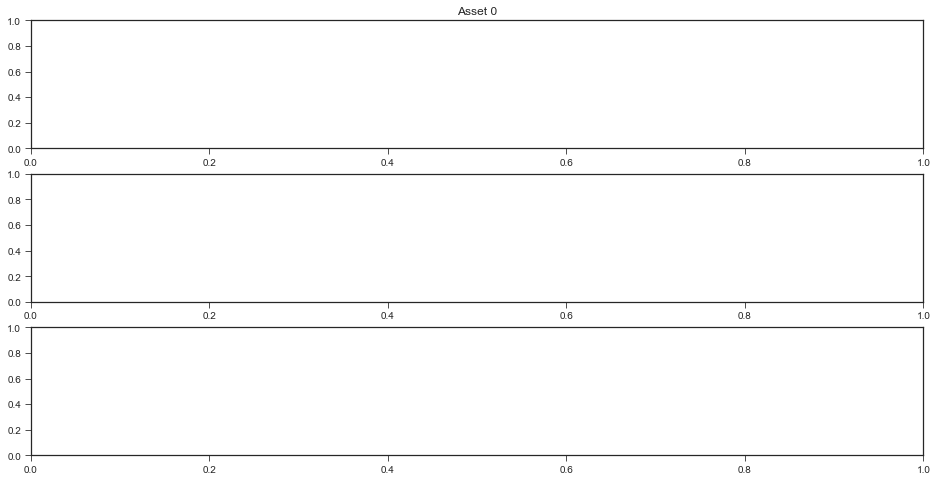

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 4

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Boom QT

IndexError: list index out of range

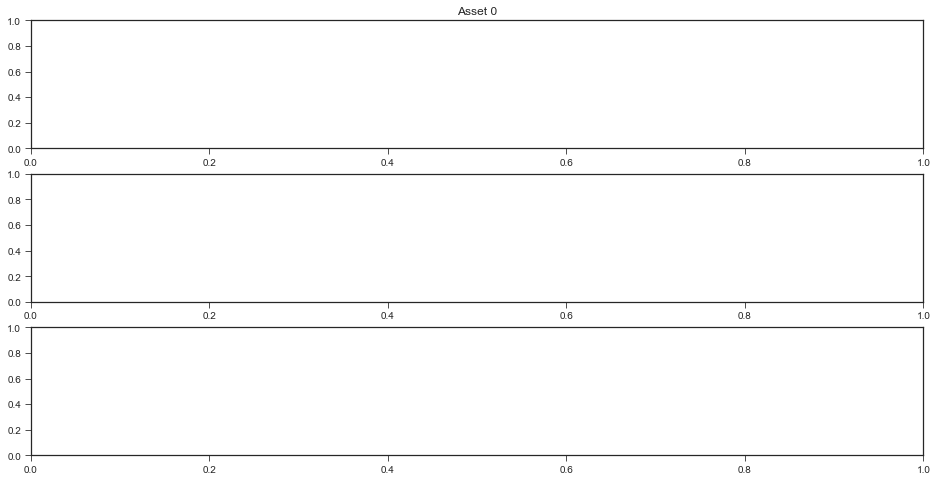

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 5

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Summary 